In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [70]:
slowniczek = {
    'biologia_laureat': "biologiczna",
    'chemia_laureat': "chemiczna",
    'fizyka_laureat': "fizyczna",
    'geografia_laureat': "geograficzna",
    'historia_laureat': "historyczna",
    'informatyka_laureat': "informatyczna",
    'j_angielski_laureat': "j. angielskiego",
    'j_polski_laureat': "j. polskiego",
    'matematyka_laureat': "matematyczna",
    'WOS_laureat': "z WOSu",
    'srednia': "(średni wynik ogółu)"
}

# ew dodac tez koincydencje z innymi przedmiotami
def koincydencje_laureatow(rok):
    df = pd.read_csv("../dane/przetworzone/sumy_laureaty_{}.csv".format(rok),
                     low_memory=False)
    
    kolumny_laureatow = [col for col in df.columns if col.endswith("_laureat")]
    df = df[kolumny_laureatow].fillna(False)

    M = np.matrix(df.values.astype(int))
    koincydencje = pd.DataFrame(M.transpose() * M, columns=kolumny_laureatow, index=kolumny_laureatow)
    
    return koincydencje

   
def srednie_laureatow(rok, znorm=False):
    if znorm:
        sciezka = "../dane/przetworzone/sumy_laureaty_{}_znorm.csv".format(rok)
    else:
        sciezka = "../dane/przetworzone/sumy_laureaty_{}.csv".format(rok)
    
    df = pd.read_csv(sciezka, low_memory=False)
    
    kolumny_laureatow = [col for col in df.columns if col.endswith("_laureat")]
    kolumny_przedmiotow = [col for col in df.columns if col.endswith("_podstawowa") or col.endswith("_rozszerzona")]

    df[kolumny_laureatow] = df[kolumny_laureatow].fillna(False)
    
    liczba = df[kolumny_laureatow].sum()
    srednie = df[kolumny_przedmiotow].mean()
    
    if znorm:
        maksima = 100
    else:
        maksima = df[kolumny_przedmiotow].max()
    
    srednie_laureatow = pd.DataFrame([df[kolumny_przedmiotow][df[col]==True].mean() for col in kolumny_laureatow],
                                     index=kolumny_laureatow)
    srednie_laureatow_proc = 100*srednie_laureatow/maksima
    srednie_laureatow_proc['liczba'] = liczba
    srednie_laureatow_proc.loc['srednia'] = 100*srednie/maksima
    srednie_laureatow_proc.loc['srednia', 'liczba'] = len(df)
    srednie_laureatow_proc.index = [slowniczek[x] for x in srednie_laureatow_proc.index]
    return srednie_laureatow_proc

In [4]:
# warto to do wykresów koincydencji
laureaci = sum([koincydencje_laureatow(rok) for rok in range(2010,2015)])

In [5]:
laureaci.columns = [slowniczek[x] for x in laureaci.columns]
laureaci.index = [slowniczek[x] for x in laureaci.index]

In [6]:
laureaci.to_csv("../d3viz/data/olimpiady_koincydencje.csv")

In [7]:
!wc -l ../dane/przetworzone/sumy_laureaty_2014.csv

  304385 ../dane/przetworzone/sumy_laureaty_2014.csv


In [8]:
358979 + 351883 + 337938 + 330502 + 304385 - 4

1683683

In [9]:
dfr = srednie_laureatow(2014)
dfr

,biologia_podstawowa,biologia_rozszerzona,chemia_podstawowa,chemia_rozszerzona,fizyka_podstawowa,fizyka_rozszerzona,geografia_rozszerzona,geografia_podstawowa,historia_podstawowa,historia_rozszerzona,...,j_angielski_rozszerzona,j_polski_rozszerzona,matematyka_rozszerzona,WOS_rozszerzona,informatyka_podstawowa,j_angielski_podstawowa,j_polski_podstawowa,matematyka_podstawowa,WOS_podstawowa,liczba
biologiczna,NaN,100.000000,NaN,83.531746,83.000000,76.666667,100.000000,NaN,NaN,NaN,...,89.145833,78.409091,61.142857,NaN,NaN,97.236842,71.492921,89.404762,NaN,84
chemiczna,NaN,83.333333,NaN,100.000000,NaN,80.246914,NaN,NaN,83.333333,NaN,...,84.283019,52.272727,76.888889,NaN,NaN,96.506849,69.612856,93.756757,NaN,74
fizyczna,NaN,90.833333,NaN,88.888889,NaN,100.000000,NaN,NaN,NaN,NaN,...,89.343750,100.000000,88.444444,NaN,NaN,95.750000,63.243243,97.288889,NaN,45
geograficzna,63.043478,81.333333,60.000000,70.238095,51.000000,66.666667,100.000000,NaN,NaN,88.000000,...,83.836735,85.353535,68.431373,77.000000,NaN,96.716418,71.288680,88.434783,NaN,69
historyczna,NaN,78.333333,NaN,75.000000,24.000000,46.666667,82.916667,85.714286,NaN,100.000000,...,81.824324,74.965035,58.555556,75.639344,28.571429,94.418367,75.238095,74.380952,NaN,105
informatyczna,NaN,NaN,NaN,NaN,NaN,75.595238,61.666667,NaN,NaN,NaN,...,86.888889,72.727273,84.400000,NaN,NaN,95.852459,59.481613,95.864407,NaN,61
j. angielskiego,NaN,81.250000,NaN,85.370370,NaN,80.277778,86.666667,NaN,NaN,85.333333,...,99.030303,76.846591,80.100000,69.200000,NaN,100.000000,73.849525,88.270270,NaN,37
j. polskiego,70.289855,75.119048,NaN,65.897436,72.000000,62.619048,77.129630,NaN,79.166667,76.714286,...,83.715232,100.000000,58.538462,68.212121,NaN,97.149068,100.000000,76.846154,NaN,183
matematyczna,NaN,83.333333,NaN,84.444444,NaN,82.500000,76.666667,NaN,NaN,NaN,...,88.753846,77.272727,100.000000,74.000000,NaN,97.616438,65.485756,100.000000,NaN,74
z WOSu,NaN,NaN,NaN,78.333333,NaN,74.444444,82.407407,NaN,90.625000,84.416667,...,83.606061,73.803828,72.923077,100.000000,NaN,93.950000,72.533784,80.750000,NaN,40


In [10]:
%%R
library(dplyr)
library(ggplot2)

laureaci_plot <- function (dfr, rok, lewo = c("j. polskiego")) {
    # hack, bo inaczej cos nie tak z konwersja
    dfr[] <- lapply(dfr, function(x) {attr(x, 'dim') <- NULL; x})
    dfr$olimpiada <- rownames(dfr)
    dfr <- filter(dfr, olimpiada != "(średni wynik ogółu)")
    
    ggplot(dfr, aes(x=j_polski_podstawowa, y=matematyka_podstawowa, label=olimpiada)) +
      geom_point(aes(size=liczba, color=j_angielski_rozszerzona)) +  # j_angielski_podstawowa
      scale_size_area() +
      scale_colour_gradient("j. angielski rozszerzona [%]", low="red", high="green") + 
      geom_text(hjust=1.2, vjust=0.4, data=filter(dfr, olimpiada %in% lewo)) +
      geom_text(hjust=-0.2, vjust=0.4, data=filter(dfr, !(olimpiada %in% lewo))) +
      #  stat_smooth(method="lm", se=F, data=filter(dfr, !(olimpiada %in% c("matematyczna", "j. polskiego")))) +
      ggtitle(paste("Finaliści i laureaci - średnie wyniki z matury", rok)) +
      labs(x="j. polski podstawowa [%]", y="matematyka podstawowa [%]")
}

/usr/local/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    filter


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/usr/local/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [11]:
dfr2010 = srednie_laureatow(2010)
dfr2011 = srednie_laureatow(2011)
dfr2012 = srednie_laureatow(2012)
dfr2013 = srednie_laureatow(2013)
dfr2014 = srednie_laureatow(2014)

In [97]:
kolumny = ['j_polski_podstawowa', 'matematyka_podstawowa', 'j_angielski_rozszerzona', 'liczba']

nowe = []
for rok in range(2010, 2015):
    df = srednie_laureatow(rok).loc[:, kolumny]
    df['olimpiada'] = df.index
    df['rok'] = rok
    nowe.append(df)

lata_zlaczone = pd.concat(nowe, ignore_index=True)

In [74]:
kolumny = ['j_polski_podstawowa', 'matematyka_podstawowa', 'j_angielski_rozszerzona', 'liczba']

nowe = []
for rok in range(2010, 2015):
    df = srednie_laureatow(rok, znorm=True).loc[:, kolumny]
    df['olimpiada'] = df.index
    df['rok'] = rok
    nowe.append(df)

lata_zlaczone_znorm = pd.concat(nowe, ignore_index=True)

In [76]:
lata_zlaczone_znorm.head()

,j_polski_podstawowa,matematyka_podstawowa,j_angielski_rozszerzona,liczba,olimpiada,rok
0,1.433639,1.727817,1.697207,83,biologiczna,2010
1,1.054042,1.991413,1.277890,72,chemiczna,2010
2,0.915513,2.149875,0.867884,30,fizyczna,2010
3,1.285396,1.689045,1.000721,70,geograficzna,2010
4,1.517898,0.900483,1.057769,84,historyczna,2010


In [12]:
dfr2010

,biologia_podstawowa,biologia_rozszerzona,chemia_podstawowa,chemia_rozszerzona,fizyka_podstawowa,fizyka_rozszerzona,geografia_rozszerzona,geografia_podstawowa,historia_podstawowa,historia_rozszerzona,...,j_angielski_rozszerzona,j_polski_rozszerzona,matematyka_rozszerzona,WOS_rozszerzona,informatyka_podstawowa,j_angielski_podstawowa,j_polski_podstawowa,matematyka_podstawowa,WOS_podstawowa,liczba
biologiczna,NaN,100.000000,74.000000,92.901235,86.023500,89.242424,80.000000,NaN,NaN,70.000000,...,92.076923,78.409091,86.000000,NaN,NaN,95.736842,76.603712,93.783133,NaN,83
chemiczna,NaN,79.809524,NaN,100.000000,90.306122,89.122807,100.000000,NaN,NaN,60.000000,...,88.166667,NaN,84.808511,NaN,NaN,94.121212,71.283784,96.472222,NaN,72
fizyczna,NaN,100.000000,NaN,97.666667,NaN,100.000000,76.666667,NaN,NaN,NaN,...,81.894737,NaN,89.714286,NaN,NaN,97.206897,69.189189,97.866667,NaN,30
geograficzna,72.826087,75.833333,NaN,87.916667,NaN,90.833333,100.000000,NaN,NaN,77.200000,...,84.208333,73.760331,75.959184,81.846154,NaN,93.937500,74.247104,92.885714,NaN,70
historyczna,NaN,NaN,92.000000,NaN,NaN,NaN,83.095238,NaN,NaN,100.000000,...,84.190476,73.352273,65.333333,81.258065,NaN,92.478261,77.300515,80.095238,NaN,84
informatyczna,82.608696,NaN,NaN,76.666667,NaN,85.530303,NaN,NaN,NaN,NaN,...,85.057143,NaN,88.111111,NaN,NaN,97.283019,71.523342,97.381818,NaN,55
j. angielskiego,82.608696,85.000000,NaN,92.916667,87.755102,75.000000,87.083333,NaN,NaN,82.250000,...,100.000000,74.053030,76.000000,73.250000,NaN,100.000000,79.292528,89.411765,97.00000,34
j. polskiego,NaN,73.611111,NaN,80.952381,87.755102,87.500000,71.444444,75.000000,75.255102,72.625000,...,84.543478,100.000000,71.520000,68.493827,NaN,95.371429,100.000000,85.175355,82.00000,212
matematyczna,NaN,NaN,NaN,85.000000,NaN,90.470085,74.285714,NaN,NaN,76.000000,...,86.804878,67.045455,100.000000,88.666667,NaN,97.839286,73.374155,100.000000,NaN,64
z WOSu,NaN,NaN,NaN,NaN,NaN,76.666667,89.375000,72.000000,88.775510,78.513274,...,81.702381,70.075758,67.750000,100.000000,NaN,92.766129,77.117117,83.546667,100.00000,150


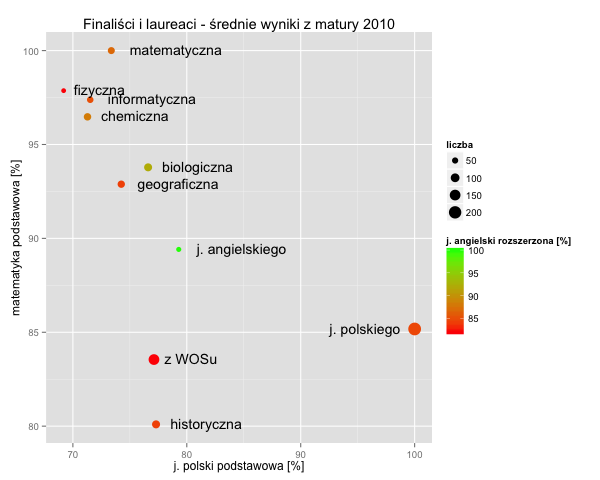

In [13]:
%%R -i dfr2010 -w 600
laureaci_plot(dfr2010, 2010)

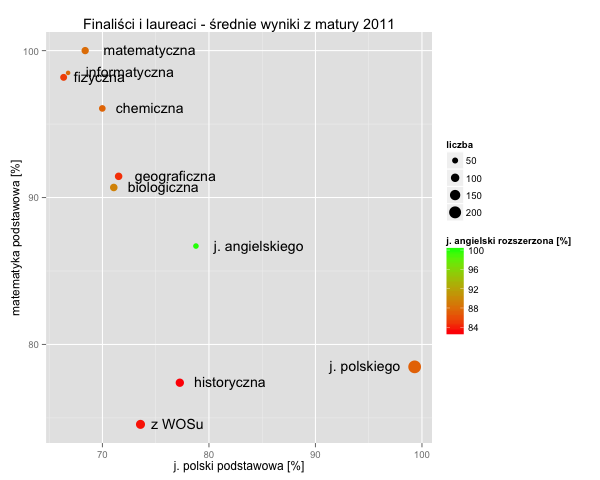

In [14]:
%%R -i dfr2011 -w 600
laureaci_plot(dfr2011, 2011)

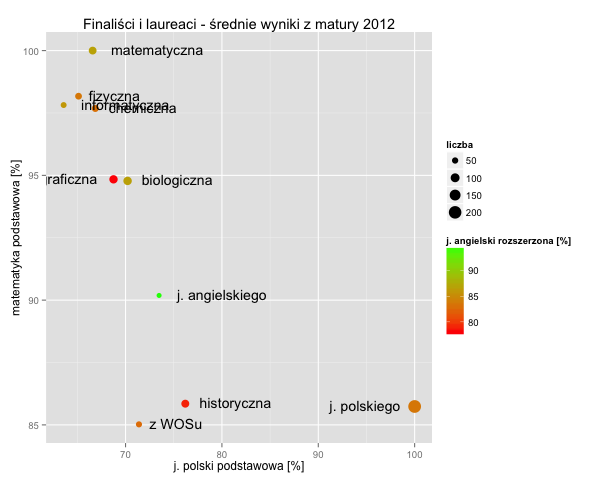

In [15]:
%%R -i dfr2012 -w 600
laureaci_plot(dfr2012, 2012, lewo = c("geograficzna", "j. polskiego"))

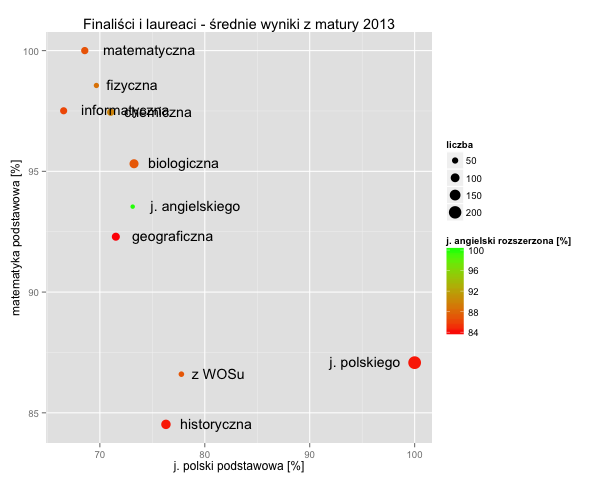

In [16]:
%%R -i dfr2013 -w 600
laureaci_plot(dfr2013, 2013)

In [71]:
dfr2014z = srednie_laureatow(2014, znorm=True)

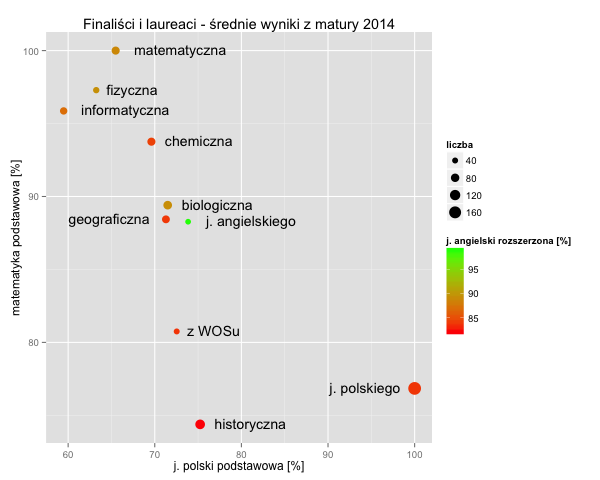

In [17]:
%%R -i dfr2014 -w 600
laureaci_plot(dfr2014, 2014, lewo = c("geograficzna", "j. polskiego"))

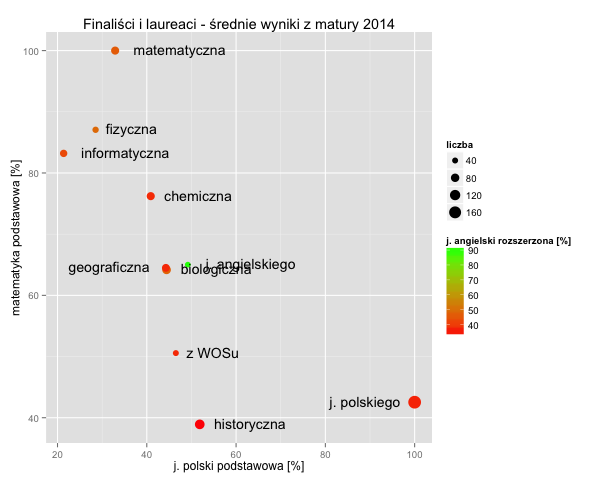

In [60]:
%%R -i dfr2014z -w 600
laureaci_plot(dfr2014z, 2014, lewo = c("geograficzna", "j. polskiego"))

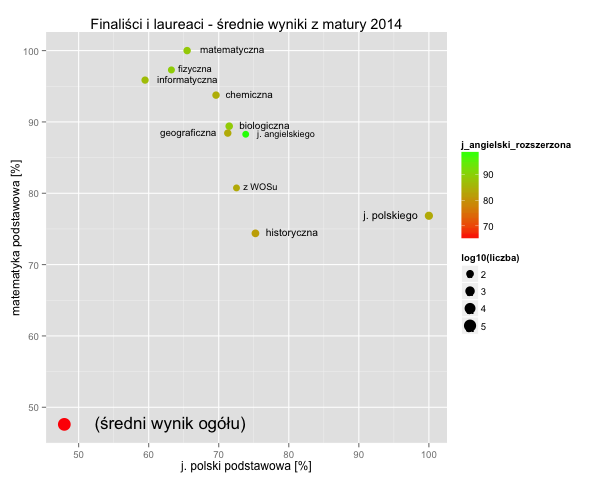

In [18]:
%%R -i dfr -w 600
library(dplyr)
library(ggplot2)

# hack, bo inaczej cos nie tak z konwersja
dfr[] <- lapply(dfr, function(x) {attr(x, 'dim') <- NULL; x})

dfr$olimpiada <- rownames(dfr)

lewo <- c("geograficzna", "j. polskiego")

ggplot(dfr, aes(x=j_polski_podstawowa, y=matematyka_podstawowa, label=olimpiada, size=log10(liczba))) +
  geom_point(aes(color=j_angielski_rozszerzona)) +  # j_angielski_podstawowa
  scale_size_area(max_size=6) +
  scale_colour_gradient(low="red", high="green") +
 # coord_cartesian("j. angielski rozszerzona [%]", xlim=c(-5, 105), ylim=c(-5, 105))
  geom_text(hjust=1.2, vjust=0.3, data=filter(dfr, olimpiada %in% lewo)) +
  geom_text(hjust=-0.2, vjust=0.3, data=filter(dfr, !(olimpiada %in% lewo))) +
  ggtitle("Finaliści i laureaci - średnie wyniki z matury 2014") +
  labs(x="j. polski podstawowa [%]", y="matematyka podstawowa [%]")

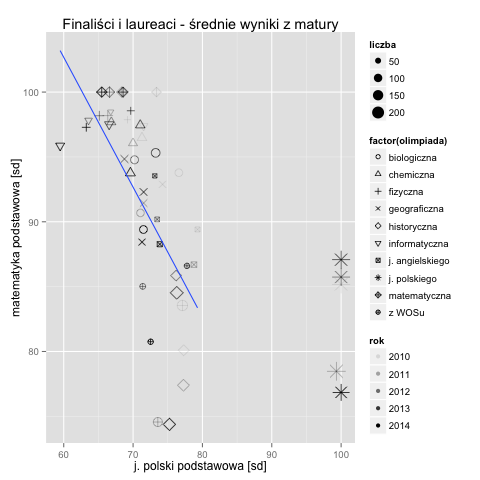

In [101]:
%%R -i lata_zlaczone

lata_zlaczone[] <- lapply(lata_zlaczone, function(x) {attr(x, 'dim') <- NULL; x})
lata_zlaczone <- filter(lata_zlaczone, olimpiada != "(średni wynik ogółu)")
    
ggplot(lata_zlaczone, aes(x=j_polski_podstawowa, y=matematyka_podstawowa)) +
  scale_shape_manual(values=1:10) +
  geom_point(aes(size=liczba, shape=factor(olimpiada), alpha=rok)) +
  scale_size_area() +
  # geom_text(hjust=1.2, vjust=0.4, data=filter(dfr, olimpiada %in% lewo)) +
  # geom_text(hjust=-0.2, vjust=0.4, data=filter(dfr, !(olimpiada %in% lewo))) +
  stat_smooth(method="lm", se=F,
              data=filter(lata_zlaczone, !(olimpiada %in% c("matematyczna", "j. polskiego")))) +
  ggtitle("Finaliści i laureaci - średnie wyniki z matury") +
  labs(x="j. polski podstawowa [sd]", y="matematyka podstawowa [sd]")

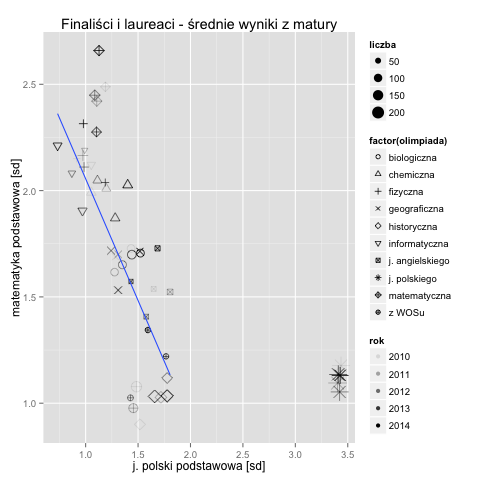

In [98]:
%%R -i lata_zlaczone_znorm

lata_zlaczone_znorm[] <- lapply(lata_zlaczone_znorm, function(x) {attr(x, 'dim') <- NULL; x})
lata_zlaczone_znorm <- filter(lata_zlaczone_znorm, olimpiada != "(średni wynik ogółu)")
    
ggplot(lata_zlaczone_znorm, aes(x=j_polski_podstawowa, y=matematyka_podstawowa)) +
  geom_point(aes(size=liczba, shape=factor(olimpiada), alpha=rok)) +
  scale_shape_manual(values=1:10) +
  scale_size_area() +
  stat_smooth(method="lm", se=F,
              data=filter(lata_zlaczone_znorm, !(olimpiada %in% c("matematyczna", "j. polskiego")))) +
  ggtitle("Finaliści i laureaci - średnie wyniki z matury") +
  labs(x="j. polski podstawowa [sd]", y="matematyka podstawowa [sd]")